# What this file does:

* define parameters of the experiment 

* define the objective function 

* find optimal of the objective function

# How the marks work:

## <span style='background :orange' > define parameters

## <span style='background :yellow' >  save data

## <span style='background :lightblue' > call saved data

# \* Start here
# trip data
##  <span style='background :orange' > define EV market penetration rate & zones

In [2]:
# define EV penetration rate (x %)
rrate = 0.6  #0.8 #0.6 #0.4 #0.2 #0.1
p_rate = rrate/100
pr = "{:.1%}".format(p_rate)
# define zone name
zzones =  'TRACT10'#'SD10' for 0.1% test; #'OBJECTID'  'TRACT10' for others

##   call geographic data, saved trips, En, Cn, initial SOC of EVs

In [3]:
import pickle
import numpy as np
import pandas as pd
import torch

EV_sample = pickle.load(open('%sEV_sample.p' %pr, "rb")) 
EV_trip = pickle.load(open('%sEV_trip.p' %pr, "rb")) 
EV_N_trips = pickle.load(open('%sEV_N_trips.p' %pr, "rb")) 
En_v = pickle.load(open('%sEn_v.p' %pr, "rb")) 
cn_v = pickle.load(open('%scn_v.p' %pr, "rb")) 
print('number of EV',len(EV_sample))
print('number of trips',len(EV_trip))

number of EV 30000
number of trips 113569


In [1]:
# call geography data
import geopandas as gpd
shapefile = gpd.read_file("Model_Traffic_Analysis_Zones_2020.shp")

Num_zone = len(shapefile[zzones].unique())
print('number of zones',Num_zone)

NameError: name 'zzones' is not defined

In [1]:
zone_array = np.sort(shapefile[zzones].unique()).tolist()
shapefile['new_zone_name'] = [zone_array.index(x)+1 for x in  shapefile[zzones]]

new_shape = shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()

NameError: name 'np' is not defined

In [19]:
print('EV_trip (in time order): end_period 1.0-48.0+, 1 = 3:00-3:30, delta 1=30min;d-taz:1-5922; distance in mile;  dwell_time: in hour')

EV_trip (in time order): end_period 1.0-48.0+, 1 = 3:00-3:30, delta 1=30min;d-taz:1-5922; distance in mile;  dwell_time: in hour


In [20]:
# change trip zone resolution
join_zones = pd.DataFrame(shapefile[['OBJECTID','new_zone_name']]).set_index('OBJECTID')
EV_trip = EV_trip.join(join_zones, on="d_taz")
EV_trip['d_taz']=EV_trip['new_zone_name']
EV_trip = EV_trip.drop(columns =['new_zone_name'])

In [21]:
# example of the EV_trip structure
EV_trip[0:5]

,end_period,d_taz,EV_list,tripID,d_purpose,distance,dwell_time
39629,1.2,50,5591648,0,work,2.0,10.40
45247,1.3,622,330774,0,escort,1.1,0.85
74431,1.3,232,2925067,0,escort,2.4,1.35
42715,1.3,792,3900900,0,school,2.7,11.35
377,1.3,914,4216331,0,shopping,1.8,1.35


In [22]:
# an example EV
EV_trip[EV_trip['EV_list']== EV_trip['EV_list'][0]]

,end_period,d_taz,EV_list,tripID,d_purpose,distance,dwell_time
0,11.2,679,24754,0,school,0.9,7.40
1,26.2,679,24754,1,othdiscr,0.9,3.40
2,33.2,679,24754,2,Home,0.9,0.90
3,36.1,486,24754,3,escort,15.0,0.45
4,38.1,679,24754,4,Home,15.0,10.45


 ### call charging behavior functions

In [23]:
%run Charging_behavior_discrete_choice_function.ipynb

##  <span style='background :orange' > define charging behavior case

In [24]:
charge_behave = 'base'
#'base' 'low_risk_sensitive' 'high_risk_sensitive' 
#'prefer_fast_charge' 'dislike_fast_charge' 
###################################
#'high_cost_sensitive' 
#'low_range_buffer'

In [25]:
beta_SOC,beta_R,beta_delta_SOC,beta_0,beta_cost,beta_SOC_0,lbd = charging_behavior_parameter(charge_behave)

In [26]:
SOC_int = pickle.load(open('%sinitial_SOC_converge_%s.p' %(pr,charge_behave), "rb")) 

 ### call charging demand simulator

charging rate (kW) [home L2, non_home L2, non_home DCFC]: [  3.6   6.2 150. ]
home charging price ($): 0.13
simulation day: 2
* charging choice parameters:
beta_SOC: 3
beta_R: 0
beta_delta_SOC: 2
beta_0: 1
beta_SOC_0: 0.3
beta_cost: 0.1
lambda: 1
* charging choice plot parameters
not-home charging price ($): 0.43
available charging type (home, non-home L2, non_home DCFC): [0, 1, 1]
total energy of EV (kWh): 60


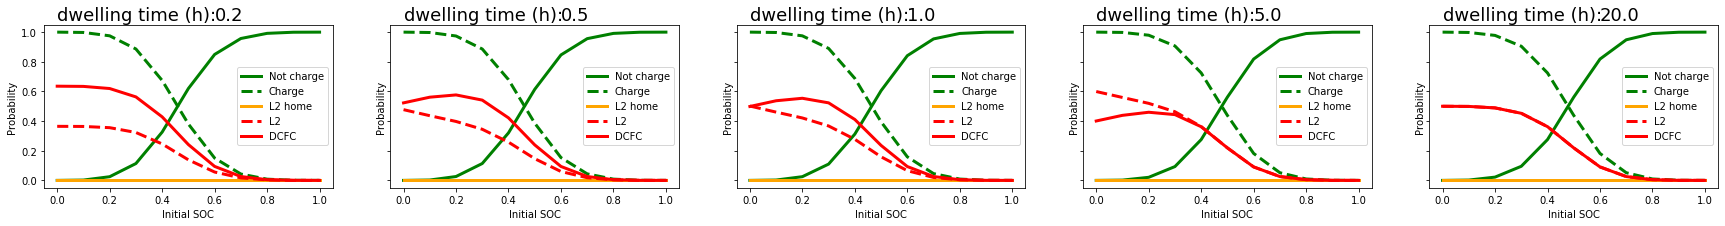

total energy of EV (kWh): 100


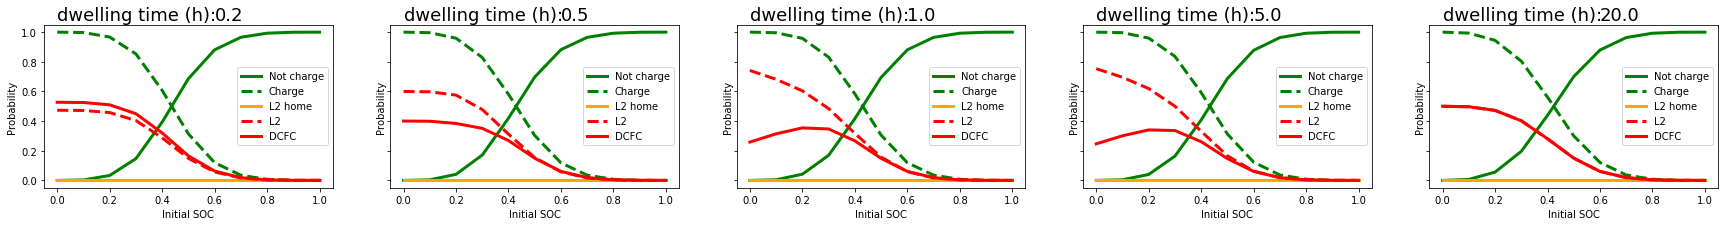

In [27]:
%run Charging_demand_simulation.ipynb

In [28]:
import os
import torch
ddtype = torch.double # need to make data format like this to avoid numerical errors

## define simulation input: charging number/taz

In [29]:
# define number of type i charger per zone, public charging price
import pandas as pd
dim = (2*Num_zone)  # dimension of variables
print("dimension of variables:",dim)


dimension of variables: 1902


##  <span style='background :orange' > define public charging price

In [30]:
pub_price =  0.43 #1.2*home_price  # public charging price
print('public charging price $:',pub_price)

public charging price $: 0.43


##  <span style='background :orange' > define objective function variables

In [31]:
year = 10 # life-cycle time

discount_rate = 0.05 # discount rate

scale_to_year = 365

station_efficiency = 0.95 

electricity_cost = 0.11 # in $/kWh  U.S average 0.07 for industry; 0.11 for commercial

L2_buy_cost = 3450 # in $

DCFC_buy_cost =  25000   # in $

L2_build_cost =  3000   # in $

DCFC_build_cost = 21000   # in $

In [32]:
present_worth_factor = ((1 + discount_rate) ** year -1)/(discount_rate * (1 + discount_rate) ** year)
#print(present_worth_factor)

In [33]:
### define high dimension cost weight
invest_cost = [L2_buy_cost + L2_build_cost] * Num_zone
invest_cost.extend([DCFC_buy_cost + DCFC_build_cost] * Num_zone)
invest_cost = torch.tensor(invest_cost,dtype = ddtype)

##   define optimization function

In [34]:
##### define NPV 

def Optimization_function(inds):
    
    inds = torch.clamp(inds, min=0, max=None) # clamp negative values to 0
    
    average_daily_demand = daily_demand_BOTorch(inds)
    #print('average_daily_demand',average_daily_demand)
    
    year_revenue = scale_to_year * pub_price * average_daily_demand 
    #print('year_revenue',year_revenue)
    
    year_electricity_cost = scale_to_year * electricity_cost * average_daily_demand / station_efficiency
    #print('year_electricity_cost',year_electricity_cost)    
    #print(inds)    
    initial_invest_cost = sum((invest_cost*inds).t()).t()
    #print('initial_invest_cost',initial_invest_cost)
    
    year_m_o_cost = 0.1 * initial_invest_cost
    #print('year_m_o_cost',year_m_o_cost)
    
    year_benefit = year_revenue - year_electricity_cost - year_m_o_cost
    #print('year_benefit',year_benefit)
    
    NPV = present_worth_factor * year_benefit - initial_invest_cost
    return NPV

## Call solution solver

In [35]:
%run Solution_solvers.ipynb

##   define search box bounds

## plot max bound 

## <span style='background :yellow' >  save results

##  <span style='background :lightblue' >  call saved results

In [36]:
import pickle
x_real_u_bound = pickle.load(open('result/%s_x_real_u_bound.p' %pr, "rb")) 
x_real_l_bound = torch.tensor([0.]*dim,dtype = ddtype)#torch.tensor([0.]*dim,dtype = ddtype)

In [37]:

x_real_bound = torch.tensor([x_real_l_bound.tolist(),x_real_u_bound],dtype = ddtype) 

##   test run the objective function value

##  <span style='background :orange' > define embedding dimension

In [38]:
### define embedding dimension
low_dim = 5

 ### embeded search space

In [39]:
# define embedding space searching box bounds
x_l_bound = -1
x_u_bound = 1

y_l_bound = -np.sqrt(low_dim)#np.sqrt(low_dim)0 #-1 #-np.sqrt(low_dim)#np.sqrt(low_dim)
y_u_bound = np.sqrt(low_dim)#np.sqrt(low_dim)#np.sqrt(low_dim)

# define y variance
y_variance = 0.1

In [40]:
## bounds for scaled x, and low dimension y, BO search bound (must be 0,1 for BOTorch)

x_scale_bound = (torch.tensor([[x_l_bound],[x_u_bound]])).repeat(1,dim).to(ddtype)

y_bound = (torch.tensor([[y_l_bound],[y_u_bound]])).repeat(1,low_dim).to(ddtype) 

#BO_bound = (torch.tensor([[0],[1]])).repeat(1,low_dim).to(ddtype)  # BOTorch search bound

##  <span style='background :Orange' > Define run parameters

In [41]:
# define how to run the simulation

N_initial = 2 # N. initial points, need to be >=2
BATCH_SIZE = 1 # N. new sample points  can't be over 1, takes too long to find optimize_acqf
N_BATCH = 100 # N. iteration each trial
N_TRIALS = 1 # N. try whole algorithm

##   test run BO

In [ ]:
%run Solution_solvers.ipynb

##   test run REMBO

##    Run results

# compare acquisition funcitons

In [5]:
%run Solution_solvers.ipynb

NameError: name 'torch' is not defined

In [6]:
import time

t0 = time.time()
Run_result = {}

#for i in range(N_TRIALS):
A_0 = gen_projection_rembo(low_dim,dim)
init_x_0, init_y_0, best_init_y_0, best_init_x_0 = generate_initial_data_REMBO(A_0,2)
for j in ['EI', 'PI', 'UCB']: #, 'PM'
    Run_result[j] = REMBO_run_ac(N_initial,BATCH_SIZE,N_BATCH,N_TRIALS,j) 

t1 = time.time()
print(t1-t0)

NameError: name 'gen_projection_rembo' is not defined

##    Add more results

## <span style='background :yellow' >  save results

##  <span style='background :lightblue' >  call saved results

In [7]:
print(pr,charge_behave)

NameError: name 'pr' is not defined

##    Show results

In [8]:
best_observed_all = Run_result[0]
best_observed_all_x = Run_result[1]
init_x = Run_result[2]
init_y = Run_result[3]

#A_all = Run_result[4] ######### Active for REMBO

KeyError: 0

# plot results

In [9]:
#####

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(len(best_observed_all)):
    ax = plt.plot(iters, y_value[i])


plt.title('Convergence')
#plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
#plt.savefig('converge/%sconverge_iteration.png'%pr,bbox_inches='tight')


plt.show()
#ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=1.5)
#ax.set_ylim(bottom=0.5)
#ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
#ax.legend(loc="lower right")

NameError: name 'best_observed_all_x' is not defined

In [ ]:
######### for REMBO 

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

iters = np.arange(len(best_observed_all_x[0]))
y_value = np.asarray(best_observed_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=0.3)
#ax.set_ylim(bottom=5500000)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
ax.legend(loc="lower right")

In [ ]:
new_shape = shapefile[['new_zone_name', 'geometry']]
new_shape = new_shape.dissolve(by='new_zone_name', aggfunc='sum')
new_shape = new_shape.reset_index()

### map best result

In [ ]:
############# plot for REMBO


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


for i in range(len(best_observed_all)):
    which_trial = i # define which trail to plot
    result_x = best_observed_all_x[which_trial][len(best_observed_all_x[0])-1]
    result_x = torch.clamp(low_to_high_dimension(A_all[i],result_x), min=0, max=None) 
    result_x = torch.reshape(result_x,(2,Num_zone)).to(dtype = ddtype).tolist()
    max_NPV = max(best_observed_all[which_trial])

    new_shape['L2'] = result_x[0]
    new_shape['DCFC'] = result_x[1]
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')

    fig, ax = plt.subplots(1, 2,figsize=(16, 8))

    new_shape.plot(column='L2', ax=ax[0], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)


    new_shape.plot(column='DCFC', ax=ax[1], legend=True,cmap='Blues',edgecolor='black',linewidth = 0.1)

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[0].get_legend().set_title('N. L2 chargers')
    ax[0].set_title('max NPV:%s M$'%(max_NPV/10**6))
    ax[1].set_title('N.l2:%s; N. DCFC:%s'%(sum(result_x[0]),sum(result_x[1])))
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')
    ax[1].get_legend().set_title('N. DCFC chargers')

#plt.savefig('best_result.png',bbox_inches='tight');


# Post evaluation: the best observation

In [10]:
######## the best observation of each trial
Best_objective = [max(best_observed_all[i]) for i in range(len(best_observed_all))]

NameError: name 'best_observed_all' is not defined

In [ ]:
Best_over_all = max(Best_objective)
best_index = Best_objective.index(Best_over_all)
Best_over_all_x = best_observed_all_x[best_index][len(best_observed_all_x[best_index])-1]
Best_over_all_A = A_all[best_index]  # for REMBO

In [ ]:

best_result_x = torch.clamp(low_to_high_dimension(Best_over_all_A,Best_over_all_x), min=0, max=None) 
best_result_x = torch.reshape(best_result_x,(2,Num_zone)).to(dtype = ddtype).tolist()
        
new_shape['L2'] = best_result_x[0]
new_shape['DCFC'] = best_result_x[1]
new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')#astype('float64')
    

fig, ax = plt.subplots(1, 1,figsize=(8,6))

new_shape.plot(column='L2', ax=ax, legend=True,legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.015,1.018)}
               ,cmap='Blues',edgecolor='black',linewidth = 0.2)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
    
ax.get_legend().set_title('No. chargers')

#plt.savefig('result/plot/best_placement_L2.png',bbox_inches='tight');


fig, ax = plt.subplots(1, 1,figsize=(8,6))

new_shape.plot(column='DCFC', ax=ax, legend=True,legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.015,1.018)}
               ,cmap='Greens',edgecolor='black',linewidth = 0.2)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
    
ax.get_legend().set_title('No. chargers')
#plt.savefig('result/plot/best_placement_DCFC.png',bbox_inches='tight');


#ax.set_title('max NPV of %s scenario:%s M$'%(charge_behave,max(mean)/10**6))



#ax[1].set_title('total number of chargers: L2 %s; DCFC %s'%(sum(new_shape['L2']),sum(new_shape['DCFC'])))


#ax[1].set_ylabel('Latitude')
#ax[1].set_xlabel('Longitude')
#ax[1].get_legend().set_title('N. DCFC chargers')


    




In [ ]:
############ best of all

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


iters = np.arange(len(best_observed_all_x[0])) 
y_value = np.amax(np.array(best_observed_all).T , 1)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = plt.plot(iters, y_value, 'k')
plt.title('best observation along all trials')
#plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
#plt.savefig('converge/%sconverge_iteration.png'%pr,bbox_inches='tight')


plt.show()
#ax.errorbar(iters, y_value.mean(axis=0), yerr=ci(y_value), label="qEI", linewidth=1.5)
#ax.set_ylim(bottom=0.5)
#ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value ($)')
#ax.legend(loc="lower right")

# find the best placement

In [ ]:
best_observed_all = Run_result[0]
best_observed_all_x = Run_result[1]
init_x = Run_result[2]
init_y = Run_result[3]

A_all = Run_result[4] ######### Active for REMBO

In [ ]:
len(best_observed_all_x)

In [11]:
best_place_

NameError: name 'best_place_' is not defined

## <span style='background :yellow' >  save results

##  <span style='background :lightblue' >  call saved results

In [12]:
placement = pickle.load(open('result/%sPlacement_REMBO_%s.p' %(pr,charge_behave), "rb")) 


NameError: name 'pr' is not defined

### Check if sample is normally distributed, and standard error

In [ ]:
for i in range(len(placement[1])):
    lst = pd.DataFrame.from_dict( [j.tolist() for j in placement[1][i][0:]] )
    #print('mean',np.mean(placement[1][i][0:]))
    #print('std',np.array(placement[1][i]).std(axis=0) )
    lst.plot.kde(figsize=[10,6],bw_method=0.5)
    

In [ ]:
mean = []
std = []

for i in range(len(placement[1])):
    mean.append(np.mean(placement[1][i][0:]))
    #print(placement[1][i][0:])
    std.append(np.array(placement[1][i]).std(axis=0) )
    
    
best_index = mean.index(max(mean))
#print(best_index)
best_place = placement[0][best_index*len(placement[1][0])]

best_place = torch.reshape(best_place,(2,Num_zone)).to(dtype = ddtype).tolist()
        
new_shape['L2'] = best_place[0]
new_shape['DCFC'] = best_place[1]
new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')#astype('float64')
    
fig, ax = plt.subplots(1, 2,figsize=(16, 8))

new_shape.plot(column='L2', ax=ax[0], legend=True,legend_kwds={'loc': 'upper left'},cmap='Blues',edgecolor='black',linewidth = 0.1)
new_shape.plot(column='DCFC', ax=ax[1], legend=True,legend_kwds={'loc': 'upper left'},cmap='Blues',edgecolor='black',linewidth = 0.1)

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
    
ax[0].get_legend().set_title('N. L2 chargers')
ax[0].set_title('max NPV of %s scenario:%s M$'%(charge_behave,max(mean)/10**6))
    #ax[0].legend(loc="upper left")
    #ax[1].legend(loc="upper left")


ax[1].set_title('total number of chargers: L2 %s; DCFC %s'%(sum(new_shape['L2']),sum(new_shape['DCFC'])))


ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].get_legend().set_title('N. DCFC chargers')

plt.savefig('result/plot/%s_best_placement_%s.png'%(pr,charge_behave),bbox_inches='tight');

In [ ]:
mean, std

# Plot results

In [49]:
####### define font size
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14})

In [50]:
import matplotlib as mpl
import numpy as np

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["steelblue", "darkorange", "forestgreen"]) 

# compare acquisition funciton

In [13]:
######## compare BO and REMBO both converge to optimal
from collections import defaultdict
# define EV penetration rate (x %)
rrate = 0.1  #1.0 #0.4 #0.2 #0.1
p_rate = rrate/100
pr = "{:.1%}".format(p_rate)

import pickle

Result1=pickle.load(open('result/%sResults_REMBO_acquisitions_1.p' %pr, "rb")) 
Result2=pickle.load(open('result/%sResults_REMBO_acquisitions_2.p' %pr, "rb")) 
Result3=pickle.load(open('result/%sResults_REMBO_acquisitions_3.p' %pr, "rb")) 
#Result4=pickle.load(open('result/%sResults_REMBO_acquisitions_4.p' %pr, "rb"))
#Result5=pickle.load(open('result/%sResults_REMBO_acquisitions_5.p' %pr, "rb"))
#Result6=pickle.load(open('result/%sResults_REMBO_acquisitions_6.p' %pr, "rb"))

                         
Result = defaultdict(list)
for i in Result1:
    New_result = []
    
    for j in range(len(Result1[i])):
        
        New_result.append( Result1[i][j] + Result2[i][j]  + Result3[i][j])#+ Result4[i][j] + Result5[i][j] + Result6[i][j])
    
    Result[i] = New_result
    
#Result.pop('PM')
#Result['EI'] = pickle.load(open('result/%sResults_REMBO_base_converge_best9.p' %pr, "rb")) 


In [14]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[ "darkorange","steelblue", "forestgreen"]) 
plt.subplots(1, 1, figsize=(8, 6))

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

for i in Result:
    best_observed_all = Result[i][0]
    #print(best_observed_all)
    best_observed_all_x = Result[i][1]
    init_x = Result[i][2]
    init_y = Result[i][3]
    
    # Plot 
    iters = np.arange(len(best_observed_all_x[0])) * 1 
    y_mean = np.asarray(best_observed_all).mean(axis=0)/10**6 
    #print(max(y_mean))
    
    iters = iters
    y_mean = y_mean
    y_std = ci(y_mean)
    
    
    if i == 'REMBO':
        ymax = y_mean[-1]
        y_max_std = y_std
    
    plt.plot(iters, y_mean, "-", label=i,linewidth = 3)
    plt.fill(np.concatenate([iters, iters[::-1]]),
             np.concatenate((y_mean-y_std,y_mean[::-1]+y_std)),
             alpha=.2) #fc="r", ec="None")

plt.legend(loc="lower right")

#plt.fill(np.concatenate([iters_REMBO, iters_REMBO[::-1]]),
#             np.concatenate((ymax-y_max_std,ymax[::-1]+y_max_std)),
#             alpha=0.3,color = 'y')
        
plt.xlabel('Number of observations')
plt.ylabel('Best observed NPV (Million $)')
#plt.grid('both')
plt.savefig('result/plot/compare_acquisition.png',bbox_inches='tight')

NameError: name 'mpl' is not defined

In [ ]:
#####

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cl = {'EI':'r', 'PI': 'b', 'UCB':'g'}

for i in Result:
    best_observed_all = Result[i][0]
    best_observed_all_x = Result[i][1]
    init_x = Result[i][2]
    init_y = Result[i][3]

    iters = np.arange(len(best_observed_all_x[0])) 
    y_value = np.asarray(best_observed_all)


    for j in range(len(best_observed_all)):
        ax = plt.plot(iters, y_value[j], color = cl[i])

plt.legend(loc="lower right")


plt.title('Convergence')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)

plt.show()

# results-converge 
##  <span style='background :lightblue' >  call saved results

In [ ]:
######## compare BO and REMBO both converge to optimal

# define EV penetration rate (x %)
rrate = 0.1  #1.0 #0.4 #0.2 #0.1
p_rate = rrate/100
pr = "{:.1%}".format(p_rate)

import pickle
Result={}

Result['REMBO'] = pickle.load(open('result/%sResults_REMBO_base_converge_best8.p' %pr, "rb")) 
Result['BO'] = pickle.load(open('result/%sResults_BO_base.p' %pr, "rb")) 
Result['Random'] = pickle.load(open('result/%sResults_Random_base_add.p' %pr, "rb")) 



In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[ "darkorange","steelblue", "forestgreen"]) 
plt.subplots(1, 1, figsize=(8, 6))

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

for i in Result:
    best_observed_all = Result[i][0]
    #print(best_observed_all)
    best_observed_all_x = Result[i][1]
    init_x = Result[i][2]
    init_y = Result[i][3]
    
    # Plot 
    iters = np.arange(len(best_observed_all_x[0])) * 1 
    y_mean = np.asarray(best_observed_all).mean(axis=0)/10**6 
    #print(max(y_mean))
    
    iters = iters
    y_mean = y_mean
    y_std = ci(y_mean)
    
    
    if i == 'REMBO':
        ymax = y_mean[-1]
        y_max_std = y_std
    
    plt.plot(iters, y_mean, "-", label=i,linewidth = 2)
    plt.fill(np.concatenate([iters, iters[::-1]]),
             np.concatenate((y_mean-y_std,y_mean[::-1]+y_std)),
             alpha=.3) #fc="r", ec="None")

plt.legend(loc="lower right")    

iters_REMBO = np.arange(90,1001)
ymax = np.asarray([ymax]*len(iters_REMBO))
plt.plot(iters_REMBO,ymax, '--', label=i,linewidth = 2,alpha = 1,color = 'darkorange')
plt.plot(iters_REMBO,ymax + y_max_std, '--', label=i,linewidth = 1,alpha = 1,color = 'darkorange')
plt.plot(iters_REMBO,ymax - y_max_std, '--', label=i,linewidth = 1,alpha = 1,color = 'darkorange')



#plt.fill(np.concatenate([iters_REMBO, iters_REMBO[::-1]]),
#             np.concatenate((ymax-y_max_std,ymax[::-1]+y_max_std)),
#             alpha=0.3,color = 'y')
        
plt.xlabel('Number of observations')
plt.ylabel('Best observed NPV (Million $)')
#plt.grid('both')
plt.savefig('result/plot/converge_iteration.png',bbox_inches='tight')

In [ ]:
#####

fig, ax = plt.subplots(1, 1, figsize=(8, 6))



for i in Result:
    best_observed_all = Result[i][0]
    best_observed_all_x = Result[i][1]
    init_x = Result[i][2]
    init_y = Result[i][3]

    iters = np.arange(len(best_observed_all_x[0])) 
    y_value = np.asarray(best_observed_all)


    for i in range(len(best_observed_all)):
        ax = plt.plot(iters, y_value[i])


plt.title('Convergence')
plt.xlabel('number of observations (beyond initial points)')
plt.ylabel('best objective value ($)')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)

plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.subplots(1, 1, figsize=(8, 6))

def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(len(best_observed_all))

for i in Result:
    best_observed_all = Result[i][0]
    best_observed_all_x = Result[i][1]
    init_x = Result[i][2]
    init_y = Result[i][3]
    
    # Plot 
    iters = np.arange(len(best_observed_all_x[0])) * BATCH_SIZE
    y_best = np.amax(np.array(best_observed_all).T , 1)/10**6
    #y_std = ci(y_mean)

    plt.plot(iters, y_best, "--", label=i)
    #plt.fill(np.concatenate([iters, iters[::-1]]),
    #         np.concatenate((y_mean-y_std,y_mean[::-1]+y_std)),
     #        alpha=.2) #fc="r", ec="None")

plt.legend(loc="lower right")    
plt.xlabel('number of observations')
plt.ylabel('best observed NPV (Million $)')
plt.grid()
    

# results-optimal placement 


##  <span style='background :lightblue' >  call saved results

In [51]:
rrate = 0.6  #1.0 #0.6 #0.4 #0.2 #0.1
p_rate = rrate/100
pr = "{:.1%}".format(p_rate)

charge_behave = 'base'
#'base' 'low_risk_sensitive' 'high_risk_sensitive' 
#'prefer_fast_charge' 'dislike_fast_charge' 
###################################
#'high_cost_sensitive' 
#'low_range_buffer'

placement = pickle.load(open('result/%sPlacement_REMBO_%s.p' %(pr,charge_behave), "rb")) 

best observed NPV mean (M$): 30.879807239691424
N. L2:%s; N. DCDC:%s (579.0, 553.0)


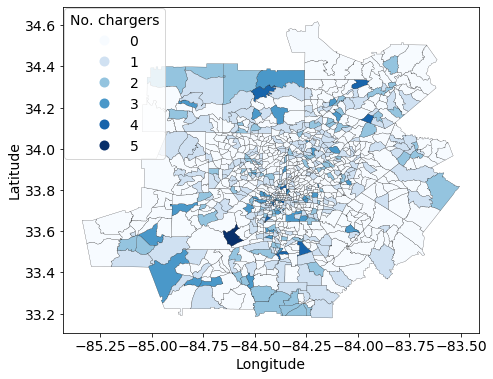

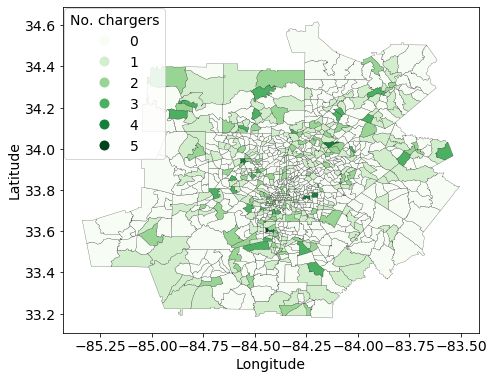

In [52]:
mean = []
std = []

for i in range(len(placement[1])):
    mean.append(np.mean(placement[1][i]))
    std.append(np.array(placement[1][i]).std(axis=0) )
best_index = mean.index(max(mean))
best_place = placement[0][best_index*len(placement[1][0])]

best_place = torch.reshape(best_place,(2,Num_zone)).to(dtype = ddtype).tolist()
        
new_shape['L2'] = best_place[0]
new_shape['DCFC'] = best_place[1]
new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')#astype('float64')
    
print('best observed NPV mean (M$):', max(mean)/10**6)
print('N. L2:%s; N. DCDC:%s', (sum(best_place[0]),sum(best_place[1])))


    
fig, ax = plt.subplots(1, 1,figsize=(8,6))

new_shape.plot(column='L2', ax=ax, legend=True,legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.015,1.018)}
               ,cmap='Blues',edgecolor='black',linewidth = 0.2)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
    
ax.get_legend().set_title('No. chargers')

plt.savefig('result/plot/best_placement_L2.png',bbox_inches='tight');




fig, ax = plt.subplots(1, 1,figsize=(8,6))

new_shape.plot(column='DCFC', ax=ax, legend=True,legend_kwds={'loc': 'upper left','bbox_to_anchor':(-0.015,1.018)}
               ,cmap='Greens',edgecolor='black',linewidth = 0.2)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
    
ax.get_legend().set_title('No. chargers')
plt.savefig('result/plot/best_placement_DCFC.png',bbox_inches='tight');



#ax.set_title('max NPV of %s scenario:%s M$'%(charge_behave,max(mean)/10**6))



#ax.set_title('total number of chargers: L2 %s; DCFC %s'%(sum(new_shape['L2']),sum(new_shape['DCFC'])))


#ax[1].set_ylabel('Latitude')
#ax[1].set_xlabel('Longitude')
#ax[1].get_legend().set_title('N. DCFC chargers')


    



# results-behavior effect 


##  <span style='background :lightblue' >  call saved results

In [53]:
rrate = 0.6  #1.0 #0.6 #0.4 #0.2 #0.1
p_rate = rrate/100
pr = "{:.1%}".format(p_rate)

behave = [ 'low_risk_sensitive', 'high_risk_sensitive' ,'prefer_fast_charge','base', 'dislike_fast_charge']

opt_place = {} # all trails
best_place = {} # the best trail

for i in behave:
    opt_place[i] = pickle.load(open('result/%sPlacement_REMBO_%s.p' %(pr,i), "rb")) 
    
    mean = []
    std = []

    for j in range(len(opt_place[i][1])):
        mean.append(np.mean(opt_place[i][1][j]))
        std.append(np.array(opt_place[i][1][j]).std(axis=0))
    print(mean)
    best_index = mean.index(max(mean[:]))
    print(best_index)
    b_place = opt_place[i][0][best_index* 20]
    
    
    best_place[i] = {}
    best_place[i]['NPV'] = [i.tolist()[0] / 10**6 for i in opt_place[i][1][best_index]]
    best_place[i]['NPV_mean'] = max(mean) 
    best_place[i]['NPV_std'] = std[best_index]
    best_place[i]['placement'] = torch.reshape(b_place,(2,Num_zone)).to(dtype = ddtype).tolist()
    best_place[i]['total Level 2'] = sum(best_place[i]['placement'][0])
    best_place[i]['total DCFC'] = sum(best_place[i]['placement'][1])

[29459412.975365907, 28997561.15226855, 27974056.721206408, 30301913.948685057, 31526475.36254088]
4
[28058432.125590086, 27573075.99510024, 26645743.87013539, 26577162.968416054]
0
[48719708.05709084, 38749211.5705292, 46883846.71837841, 45422467.87227376]
0
[16192080.31799292, 30438789.72913047, 28843354.9861027, 29114669.119407643, 29540605.76022449, 30614298.9429371, 29311994.90142861, 30587354.829903804, 30879807.239691425]
8
[13174619.096833449, 12675971.428906726, 11923017.483053556, 12068770.649232347, 11978584.39599598, 12680305.532807503]
0


In [54]:
best_dic = pd.DataFrame.from_dict(best_place, orient='index')

In [55]:
best_dic

,NPV,NPV_mean,NPV_std,placement,total Level 2,total DCFC
low_risk_sensitive,"[32.20922962063242, 32.65990867977429, 28.9267...",3.152648e+07,1.300936e+06,"[[0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 4.0, 2.0, 2.0,...",585.0,581.0
high_risk_sensitive,"[28.196088266346155, 27.11680593182414, 28.561...",2.805843e+07,9.187586e+05,"[[0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0,...",575.0,582.0
prefer_fast_charge,"[50.61889424464911, 46.26378169244437, 48.2558...",4.871971e+07,1.475665e+06,"[[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0,...",590.0,570.0
base,"[30.61255799379234, 30.020609794121025, 30.776...",3.087981e+07,1.068801e+06,"[[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0,...",579.0,553.0
dislike_fast_charge,"[13.205949264135123, 13.96098822724574, 14.289...",1.317462e+07,9.729117e+05,"[[0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0,...",561.0,567.0


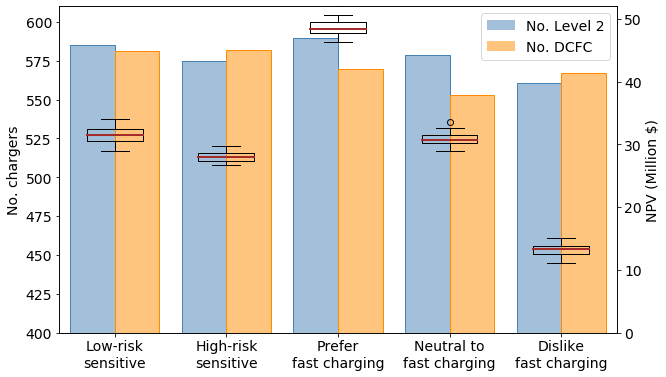

In [58]:
#best_dic[['total Level 2','total DCFC']].plot.bar(rot=0,figsize=(10, 5) )

taz_length = len(best_dic)
    
x = np.arange(1,taz_length + 1)#np.arange(len(new_shape)) # 
width = 0.4  # the width of the bars

list1 = best_dic['total Level 2'].tolist()
list2 = best_dic['total DCFC'].tolist()
list3 = best_dic['NPV'].tolist()

 


fig, ax = plt.subplots(1, 1, figsize=(10, 6))


rects1 = ax.bar(x - width/2, list1, width, label='No. Level 2', alpha = 0.5)
rects2 = ax.bar(x + width/2, list2, width, label='No. DCFC',  alpha = 0.5)

rects1 = ax.bar(x - width/2, list1, width,  fill=False, 
                edgecolor='steelblue',linewidth = 1)
rects2 = ax.bar(x + width/2, list2, width, fill=False, 
                edgecolor='darkorange',linewidth = 1)

ax2 = ax.twinx()

rects3 = ax2.boxplot(list3, medianprops=dict(color='brown', linewidth=2) )


ax2.set_ylabel('NPV (Million $)')
ax2.set_ylim([0, 52])
    # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([400, 610])
#ax.set_xlim([0, taz_length + 1])


ax.set_ylabel('No. chargers')
#ax.set_xlabel('TAZ')
#ax.set_title(i) 
#plt.xticks(x,['low risk sensitive', 'high risk sensitive', 'prefer fast charge', 'neutral to fast charge', 'dislike fast charge'],rotation=90)

ax.set_xticklabels( ['Low-risk\nsensitive', 'High-risk\nsensitive', 
              'Prefer\nfast charging', 'Neutral to\nfast charging', 'Dislike\nfast charging'],rotation=0)


ax.legend(loc='upper right')
plt.savefig('result/plot/compare_behavior.png',bbox_inches='tight');
plt.show()



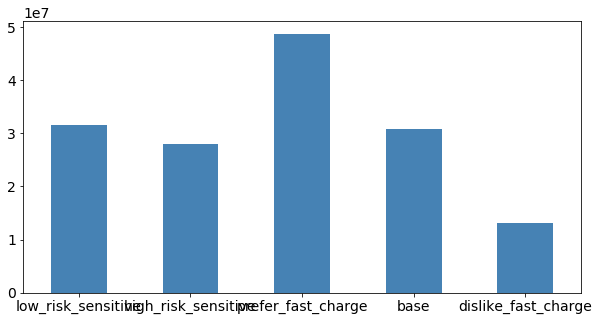

In [59]:
best_dic['NPV_mean'].plot.bar(rot=0,figsize=(10, 5) )

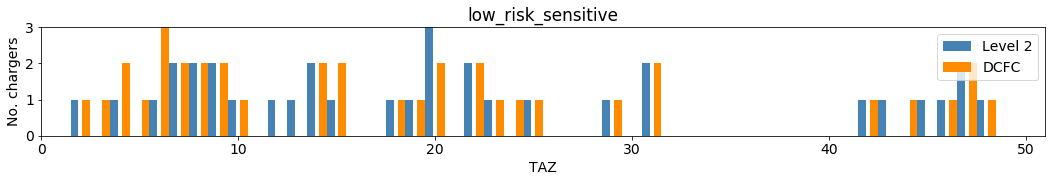

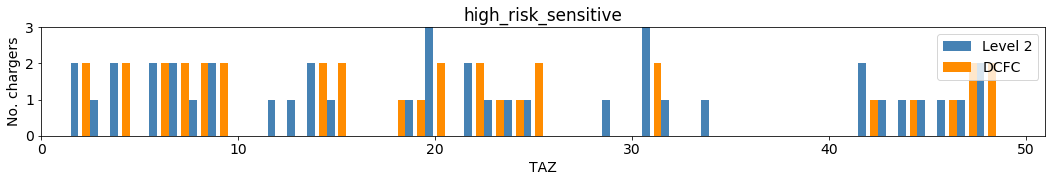

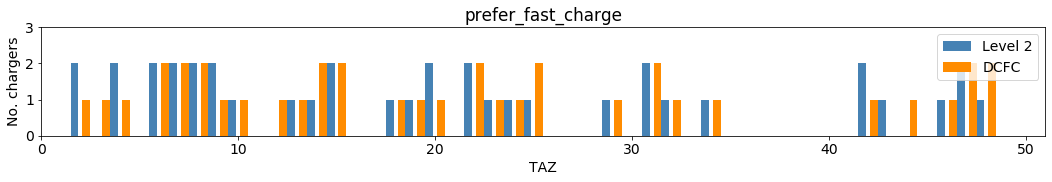

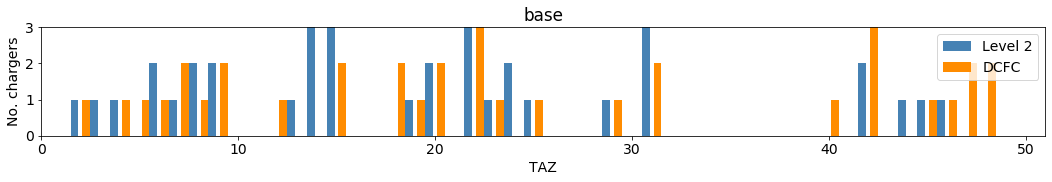

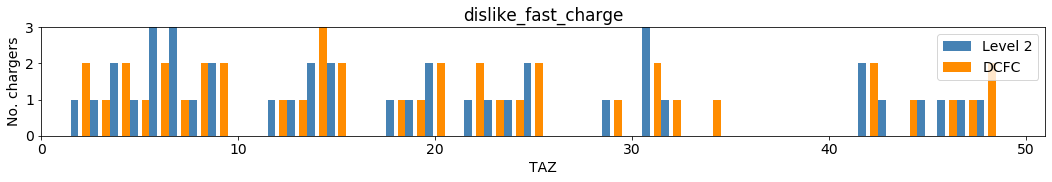

In [60]:
for i in behave:
    
    taz_length = 50
    new_shape['L2'] = best_place[i]['placement'][0]
    new_shape['DCFC'] = best_place[i]['placement'][1] 
    new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')
    
    x = np.arange(taz_length)#np.arange(len(new_shape)) # 
    width = 0.4  # the width of the bars

    list1 = new_shape['L2'].tolist()[0: taz_length]
    list2 = new_shape['DCFC'].tolist()[0: taz_length]

    fig, ax = plt.subplots(1, 1, figsize=(18, 2))
    rects1 = ax.bar(x - width/2-0.1, list2, width, label='Level 2')
    rects2 = ax.bar(x + width/2+0.1, list1, width, label='DCFC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylim([0, 3])
    ax.set_xlim([0, taz_length + 1])


    ax.set_ylabel('No. chargers')
    ax.set_xlabel('TAZ')
    ax.set_title(i) 


    ax.legend(loc='upper right')
    plt.savefig('graph/%s_scenario_%s.png'%(pr,i),bbox_inches='tight');
    plt.show()

    

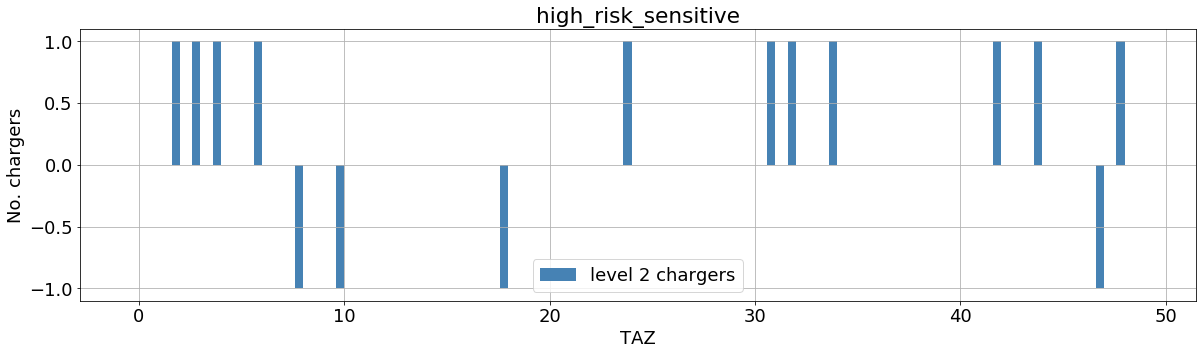

In [61]:
plt.rcParams.update({'font.size': 18})



['base', 'low_risk_sensitive', 'high_risk_sensitive' ,'prefer_fast_charge', 'dislike_fast_charge']

i = 'high_risk_sensitive'

j = 'low_risk_sensitive'
new_shape['L2'] = np.subtract(best_place[i]['placement'][0] , best_place[j]['placement'][0])
new_shape['DCFC'] = np.subtract(best_place[i]['placement'][1] , best_place[j]['placement'][1])
new_shape[['L2','DCFC']] = new_shape[['L2','DCFC']].astype('Int64')
    
x = np.arange(taz_length) # the label locations
width = 0.4  # the width of the bars

list1 = new_shape['L2'].tolist()[0: taz_length]
list2 = new_shape['DCFC'].tolist() [0: taz_length]

#list2 = np.add(list1,list2)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
rects1 = ax.bar(x - width/2, list2, width, label='level 2 chargers')
#rects2 = ax.bar(x + width/2, list1, width, label='DCFC chargers')

    # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. chargers')
ax.set_xlabel('TAZ')
ax.set_title(i) 


plt.grid()


ax.legend()
plt.savefig('graph/%s_test.png'%pr,bbox_inches='tight');
plt.show()
    

# market share effect 


##  <span style='background :lightblue' >  call saved results

In [62]:
from statistics import median


p_rate = [0.001, 0.002, 0.004, 0.006] #, 0.008]

behave = [ 'prefer_fast_charge','base', 'dislike_fast_charge']

#res = {} # all trails
best = {}
best_num = {}
    
for i in behave:
    best[i] = {}
    best_num[i] = {}
    #print(i)
    for j in p_rate:
                
        if j <= 0.002:
            x_real_l_bound = torch.tensor([-1.]*dim,dtype = ddtype)
        else:
            x_real_l_bound = torch.tensor([0.]*dim,dtype = ddtype)
            
        j1 = "{:.1%}".format(j)
        x_real_u_bound = pickle.load(open('result/%s_x_real_u_bound.p' %j1, "rb"))         
        res = pickle.load(open('result/%sResults_REMBO_%s.p' %(j1,i), "rb"))
        
        best_NPV = sorted([max(i) for i in res[0]], reverse = True)
        
        bb_place = []
        for k in range(len(res[0])):
        
            b_place = res[1][k][-1]
            b_A = res[4][k] 
                
            add = torch.clamp(low_to_high_dimension(b_A,b_place), min=0, max=None).tolist() 
                       
            bb_place.append( sum(add) )
        #print(len(best_NPV),best_NPV[0:12])
        if len(best_NPV) > 6:
            best[i][j] = max(np.mean(best_NPV[0:8]),0) / 10 ** 6 # unit, Million
        else:
            best[i][j] = max(np.mean(best_NPV[0:5]),0) / 10 ** 6
        best_num[i][j] =  np.mean(bb_place)

In [63]:
best
#best_num

{'prefer_fast_charge': {0.001: 0.028105337097360322,
  0.002: 0.8896333562191376,
  0.004: 18.431674294113687,
  0.006: 52.44449517457124},
 'base': {0.001: 0.0,
  0.002: 0.05876213200803632,
  0.004: 7.69174844374265,
  0.006: 31.336709199787407},
 'dislike_fast_charge': {0.001: 0.0,
  0.002: 0.0,
  0.004: 0.0,
  0.006: 13.685508874877337}}

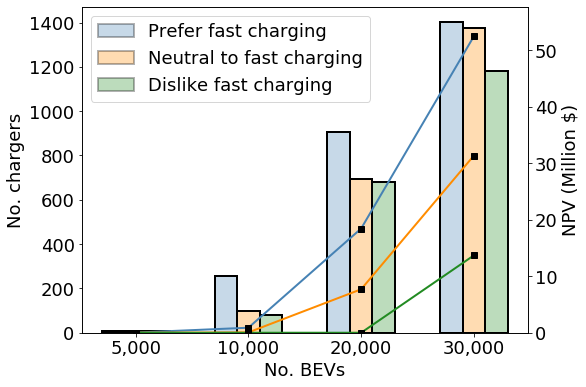

In [65]:

width = 0.4  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

list1 = list(best_num['prefer_fast_charge'].values())

list2 = list(best_num['base'].values())

list3 = list(best_num['dislike_fast_charge'].values())

npv1 = list(best['prefer_fast_charge'].values())
npv2 = list(best['base'].values())
npv3 = list(best['dislike_fast_charge'].values())




taz_length = len(list1)
    
x = np.arange(taz_length)#np.arange(len(new_shape)) # 




rects1 = ax.bar(x - width/2, list1, width/2, label='Prefer fast charging',alpha = 0.3,
                edgecolor='black',linewidth = 2)
rects2 = ax.bar(x , list2, width/2, label='Neutral to fast charging',  alpha = 0.3,
                edgecolor='black',linewidth = 2)
rects3 = ax.bar(x + width/2, list3, width/2, label='Dislike fast charging',  alpha = 0.3,
                 edgecolor='black',linewidth = 2)

rects1 = ax.bar(x - width/2, list1, width/2, fill=False, 
                edgecolor='black',linewidth = 2)
rects2 = ax.bar(x , list2, width/2, fill=False, 
                 edgecolor='black',linewidth = 2)
rects3 = ax.bar(x + width/2, list3, width/2,  fill=False, 
                 edgecolor='black',linewidth = 2)

ax2 = ax.twinx()
ax2.set_ylim([-0.01, max(npv1)*1.1])


ax2.set_ylabel('NPV (Million $)')
ax2 = plt.plot(npv1, linestyle = 'solid',marker = 's',
               linewidth = 2,ms = 6,mec = 'black', mfc = 'black')
ax2 = plt.plot(npv2, linestyle = 'solid',marker = 's',
               linewidth = 2,ms = 6,mec = 'black', mfc = 'black')
ax2 = plt.plot(npv3, linestyle = 'solid',marker = 's',
               linewidth = 2,ms = 6,mec = 'black', mfc = 'black')



plt.xticks(x, ['5,000', '10,000', '20,000','30,000','40,000'],rotation=0)

 # Add some text for labels, title and custom x-axis tick labels, etc.
    

ax.set_ylabel('No. chargers')
ax.set_xlabel('No. BEVs')





ax.legend(loc='upper left')
plt.savefig('Result/plot/market_share_NPV.png',bbox_inches='tight');
plt.show()

